In [1]:
import os
import sncosmo
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from corner import corner

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

In [3]:
data_path = '/home/samdixon/jla_light_curves/'

In [4]:
fname = 'lc-05D2ah.list'
lc = sncosmo.read_lc(os.path.join(data_path, fname), format='salt2', expand_bands=True, read_covmat=True)

# Fixed redshift

In [5]:
model = sncosmo.Model(source='snemo7')
z = lc.meta['Z_HELIO']
bounds = {}
try:
    t0 = float(lc.meta['DayMax'].split()[0])
    bounds['t0'] = (t0-5, t0+5)
except KeyError:
    t0 = np.mean(lc['Date'])
    bounds['t0'] = (min(lc['Date'])-20, max(lc['Date']))
for param_name in model.source.param_names[1:]:
    bounds[param_name] = (-100, 100)
model.set(z=z, t0=t0)
minuit_result, minuit_fit_model = sncosmo.fit_lc(lc,
                                                 model,
                                                 model.param_names[1:],
                                                 phase_range=(-10, 40))
emcee_result, emcee_fit_model = sncosmo.mcmc_lc(sncosmo.select_data(lc, minuit_result['data_mask']),
                                                minuit_fit_model,
                                                model.param_names[1:],
                                                guess_t0=False,
                                                bounds=bounds,
                                                warn=False,
                                                nwalkers=20)

/home/samdixon/miniconda3/lib/python3.6/site-packages/sncosmo-1.6.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: megacampsf::z at 11.212149(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


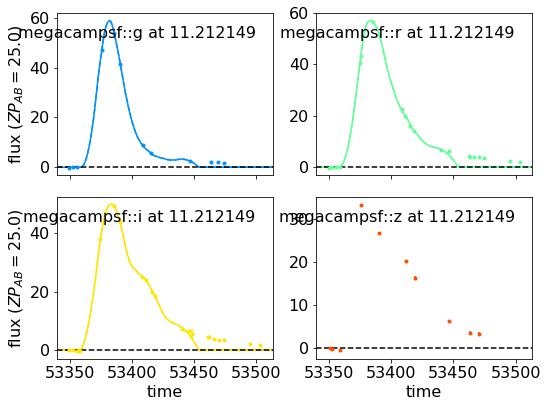

In [6]:
sncosmo.plot_lc(lc, [emcee_fit_model, minuit_fit_model]);

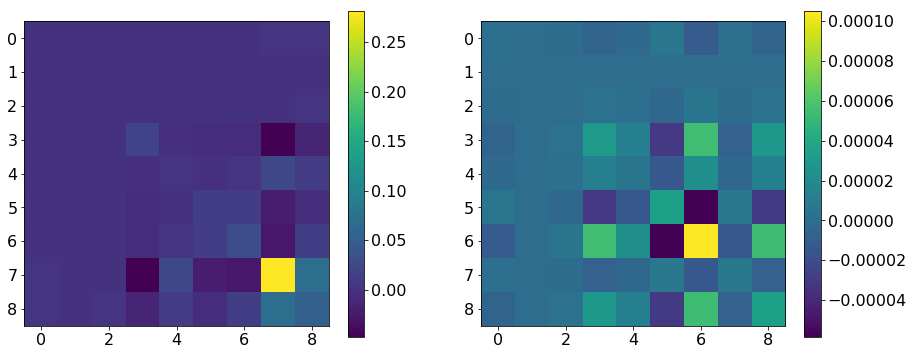

In [7]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(emcee_result.covariance)
plt.colorbar()
plt.subplot(122)
plt.imshow(minuit_result.covariance)
plt.colorbar()

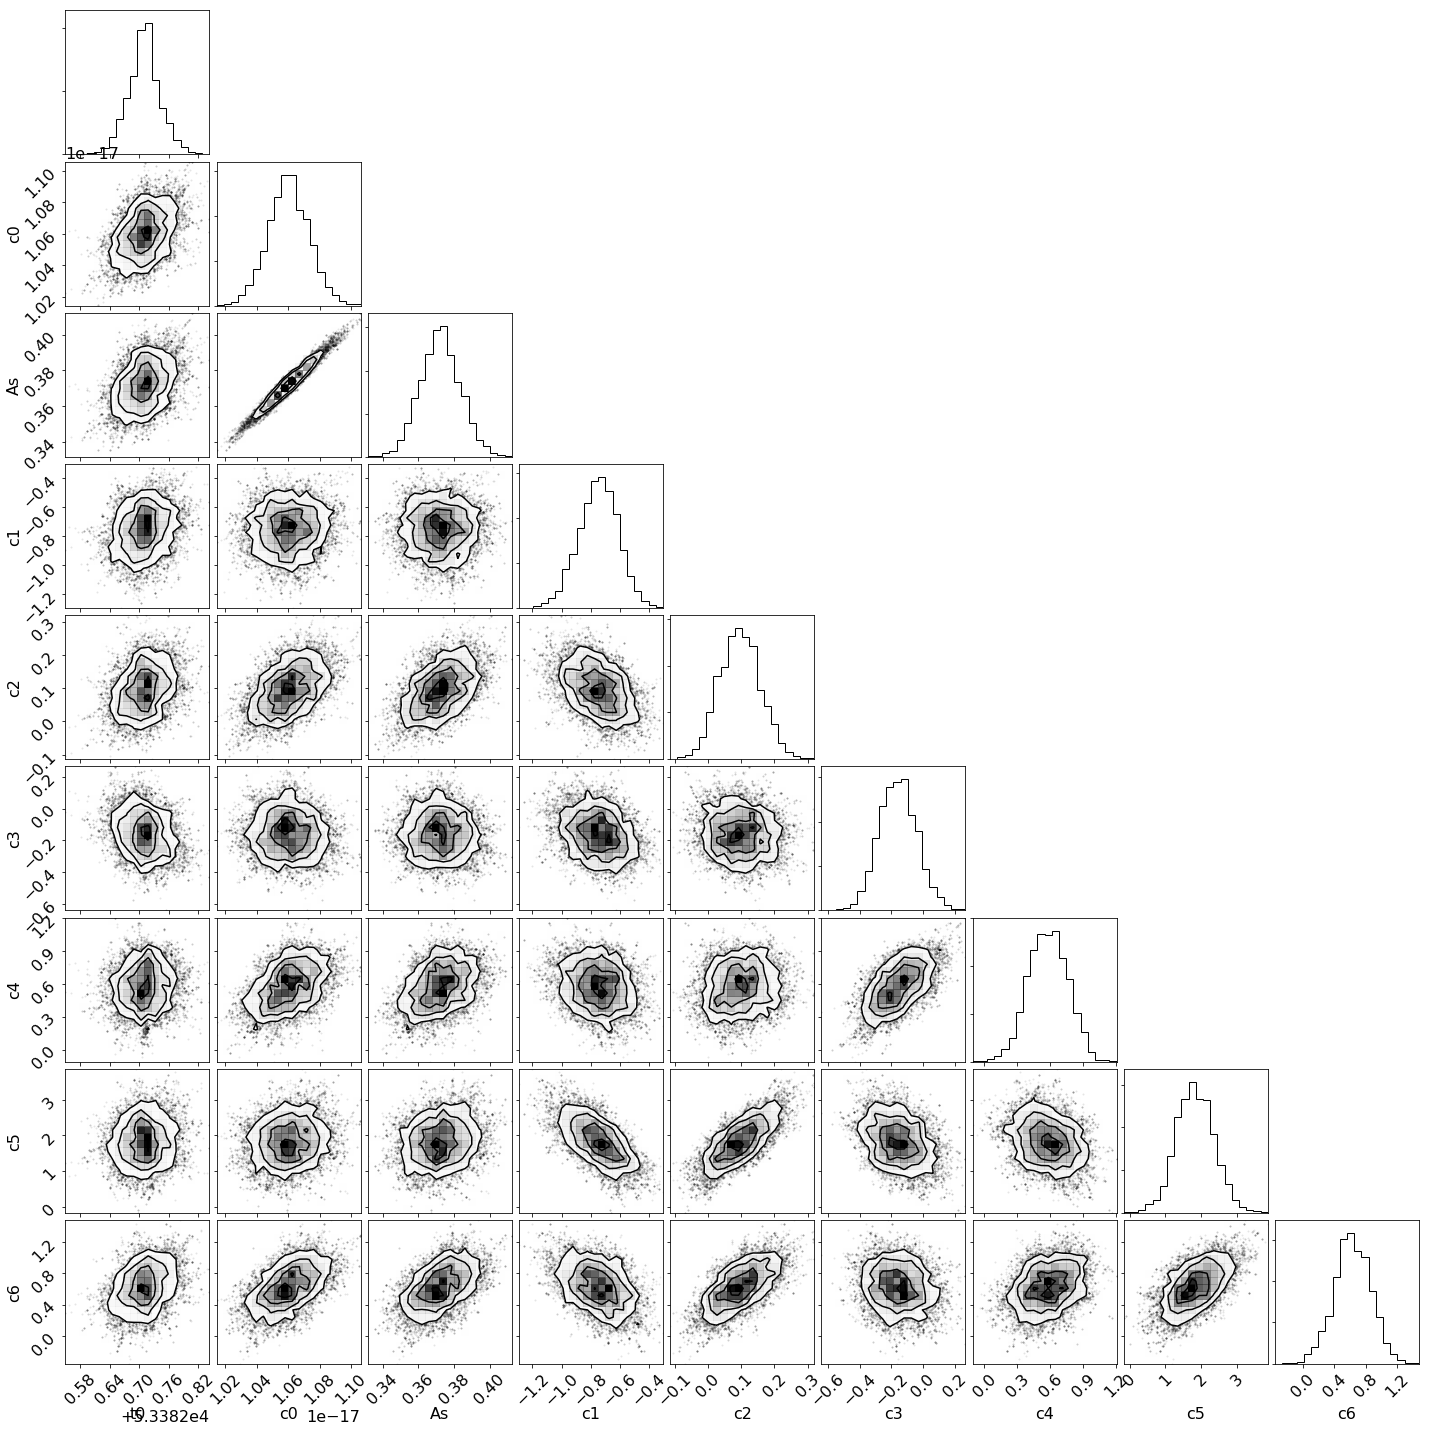

In [8]:
corner(emcee_result.samples, labels=model.param_names[1:]);

In [9]:
emcee_result.samples.shape

(20000, 9)

In [10]:
def gelman_rubin(chain):
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    θb = np.mean(chain, axis=1)
    θbb = np.mean(θb, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1) * np.sum((θbb - θb)**2, axis=0)
    var_θ = (n - 1) / n * W + 1 / n * B
    R̂ = np.sqrt(var_θ / W)
    return R̂

In [11]:
gelman_rubin(emcee_result.samples[:10])

0.9428090415829959

# Error floor

In [38]:
from astropy.table import Table

In [39]:
data = sncosmo.photdata.photometric_data(lc).normalized(zp=25., zpsys='ab')
new_lc = {'time': data.time,
          'band': data.band,
          'flux': data.flux,
          'fluxerr': data.fluxerr,
          'zp': data.zp,
          'zpsys': data.zpsys}
for band in set(data.band):
    band_cut = data.band==band
    max_flux_in_band = np.max(data.flux[band_cut])
    new_lc['fluxerr'][band_cut] = np.sqrt((0.03*max_flux_in_band)**2+data.fluxerr[band_cut]**2)
new_lc = Table(new_lc)

In [40]:
model = sncosmo.Model(source='snemo7')
z = lc.meta['Z_HELIO']
bounds = {}
try:
    t0 = float(lc.meta['DayMax'].split()[0])
    bounds['t0'] = (t0-5, t0+5)
except KeyError:
    t0 = np.mean(lc['Date'])
    bounds['t0'] = (min(lc['Date'])-20, max(lc['Date']))
for param_name in model.source.param_names[1:]:
    bounds[param_name] = (-100, 100)
model.set(z=z, t0=t0)
minuit_result, minuit_fit_model = sncosmo.fit_lc(new_lc,
                                                 model,
                                                 model.param_names[1:],
                                                 phase_range=(-10, 40))
emcee_result, emcee_fit_model = sncosmo.mcmc_lc(sncosmo.select_data(new_lc, minuit_result['data_mask']),
                                                minuit_fit_model,
                                                model.param_names[1:],
                                                guess_t0=False,
                                                bounds=bounds,
                                                warn=False,
                                                nwalkers=20)

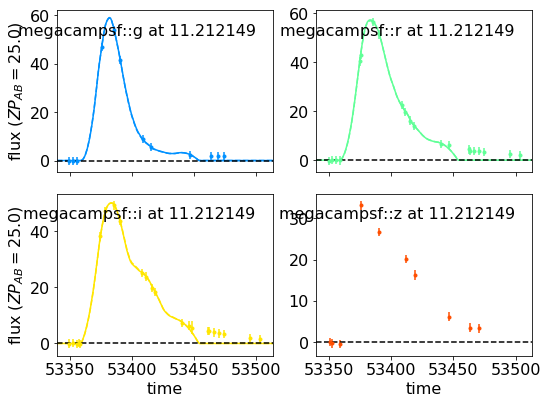

In [41]:
sncosmo.plot_lc(new_lc, [emcee_fit_model, minuit_fit_model]);

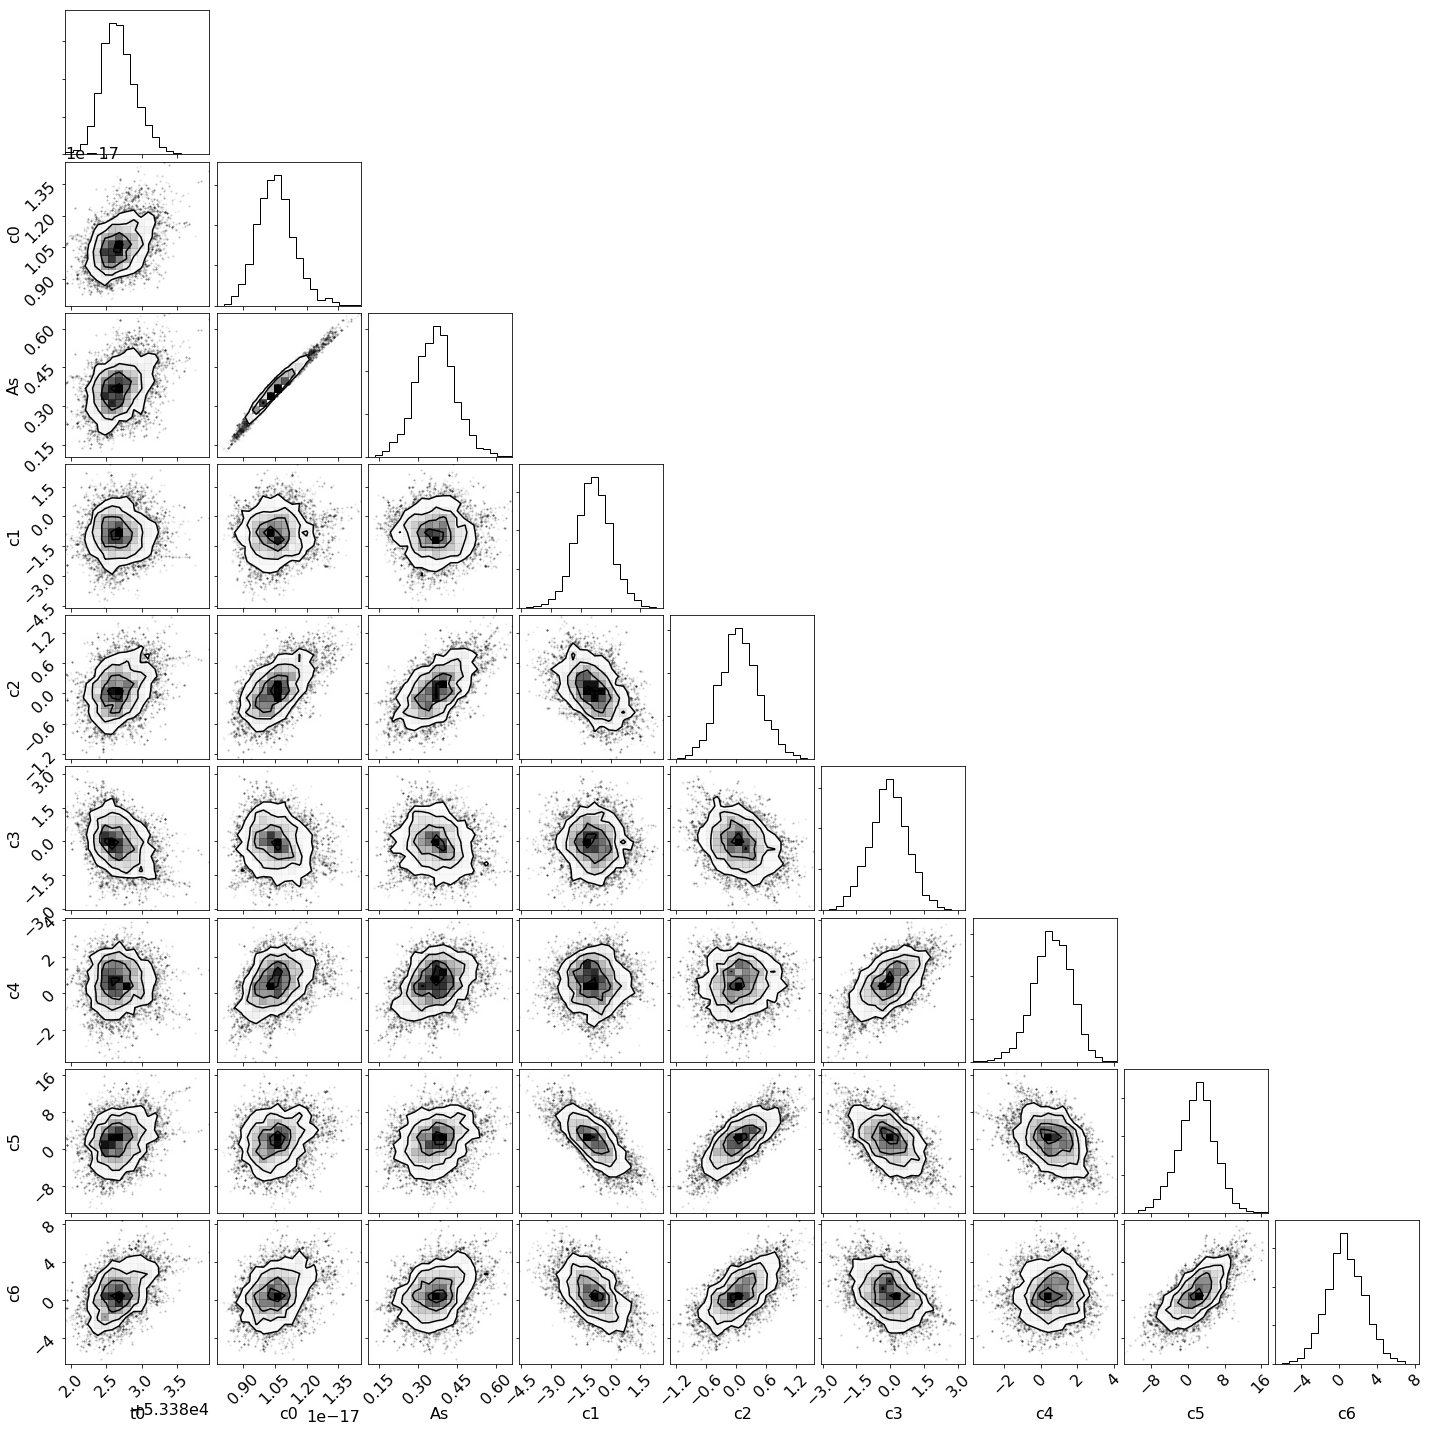

In [42]:
corner(emcee_result.samples, labels=model.param_names[1:]);

In [44]:
emcee_result['errors']

OrderedDict([('t0', 0.2455618561594944),
             ('c0', 8.80821362568348e-19),
             ('As', 0.07641242257909032),
             ('c1', 0.8984086150450573),
             ('c2', 0.3956486395504864),
             ('c3', 0.8521048706314829),
             ('c4', 1.0349375730320591),
             ('c5', 3.98053591152322),
             ('c6', 1.9954326673646217)])

In [45]:
gelman_rubin(emcee_result.samples)

0.9428090420673582